In [4]:
import os 

import numpy as np
import matplotlib.pyplot as plt
import imageio as iio

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, PyTree 

import equinox as eqx

from tqdm import tqdm, trange

### load data

In [2]:
import os
images = np.zeros((3743,480,553,4))

ii = 0
for i in trange(len(os.listdir('/pscratch/sd/s/seanjx/images'))):
    image = os.listdir('/pscratch/sd/s/seanjx/images')[i]
    if not "DS_Store" in image and not "ipynb" in image:
        images[ii] = iio.imread("/pscratch/sd/s/seanjx/images/"+image)
        ii += 1

/tmp/ipykernel_351210/4049043409.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images[ii] = iio.imread("/pscratch/sd/s/seanjx/images/"+image)
100%|██████████| 3743/3743 [00:53<00:00, 69.76it/s]


In [8]:
images = jnp.array(images[...,:3].transpose(0,3,1,2)/255)

In [14]:
### normalize
means = jnp.mean(images, axis=(0,2,3))
stds = jnp.std(images,axis=(0,2,3))
images = ((images.transpose(0,3,2,1)-means)/stds).transpose(0,3,2,1)

### model specification (make sure is same as trained model)

In [5]:
class Encoder(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4, key5, key6, key7, key8, key9 = jax.random.split(key, 9)
        # Standard CNN setup: convolutional layer, followed by flattening,
        # with a small MLP on top.
        self.layers = [
            eqx.nn.Conv2d(3, 48, kernel_size=3, key=key1, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key2, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key3, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key4, padding=1, padding_mode='REPLICATE'),
            eqx.nn.MaxPool2d(kernel_size=2,stride=2),
            jax.nn.elu,
            jnp.ravel,
            eqx.nn.Linear(48960, 8192, key=key5),
            jax.nn.elu,
            eqx.nn.Linear(8192, 1024, key=key6),
            jax.nn.elu,
            eqx.nn.Linear(1024, 64, key=key7),
            jax.nn.tanh,
        ]

    def __call__(self, x: Float[Array, "3 480 553"]):
        for layer in self.layers:
            x = layer(x)
        return x


class Decoder(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4, key5, key6, key7, key8, key9 = jax.random.split(key, 9)
        self.layers = [
            eqx.nn.Linear(64, 1024, key=key1),
            jax.nn.elu,
            eqx.nn.Linear(1024, 8192, key=key2),
            jax.nn.elu,
            eqx.nn.Linear(8192, 48960, key=key3),
            jax.nn.elu,
            lambda x: jnp.reshape(x,(48,30,34)),
            lambda x: jax.image.resize(x,(48,60,68),"nearest"),
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key9, padding=1, padding_mode='REPLICATE'),
            lambda x: jax.image.resize(x,(48,120,136),"nearest"),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key5, padding=1, padding_mode='REPLICATE'),
            lambda x: jax.image.resize(x,(48,240,272),"nearest"),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 48, kernel_size=3, key=key6, padding=1, padding_mode='REPLICATE'),
            lambda x: jax.image.resize(x,(48,480,553),"nearest"),
            jax.nn.elu,
            eqx.nn.Conv2d(48, 3, kernel_size=3, key=key7, padding=1, padding_mode='REPLICATE'),
            lambda x: 10*jax.nn.tanh(x)
            # jax.nn.relu,
        ]
    @eqx.filter_jit
    def __call__(self, x: Float[Array, "3 480 553"]):
        for layer in self.layers:
            x = layer(x)
        return x

class Autoencoder(eqx.Module):
    layers: list
    def __init__(self, key):
        key1, key2 = jax.random.split(key,2)
        self.layers = [
            Encoder(key1),
            Decoder(key2)
        ]
    @eqx.filter_jit
    def __call__(self, x: Float[Array, "3 480 553"]) -> Float[Array, "3 480 553"]:
        for layer in self.layers:
            x = layer(x)
        return x

### load model

In [6]:
model = eqx.tree_deserialise_leaves('/pscratch/sd/s/seanjx/model48.eqx',Autoencoder(jax.random.key(0)))

### pca and analysis

In [9]:
vectors = [] 
for im in tqdm(images):
    vectors.append(model.layers[0](im))
np.save('latent_vectors.npy', vectors)

100%|██████████| 3743/3743 [00:23<00:00, 157.76it/s]


<BarContainer object of 16 artists>

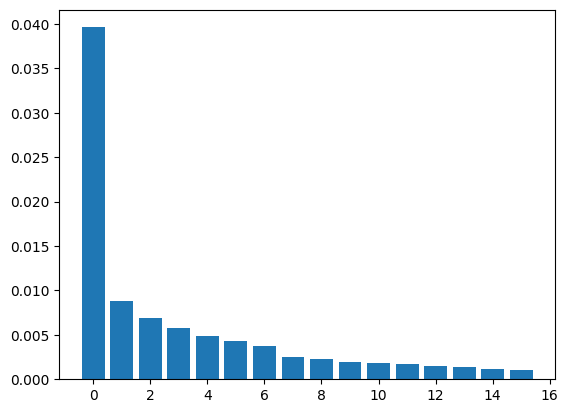

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
pca.fit(vectors)
plt.bar(np.arange(16),pca.explained_variance_)

In [11]:
img_3190 = model.layers[0](images[3190])
img_3100 = model.layers[0](images[3100])
img_2100 = model.layers[0](images[2100])
pca.transform(img_3190.reshape(1, -1)), pca.transform(img_3100.reshape(1, -1)), pca.transform(img_2100.reshape(1, -1))

(array([[ 0.17179725, -0.18386539, -0.14411317,  0.00392909, -0.06886328,
          0.08911592,  0.07597686,  0.07705603, -0.01884196,  0.01056072,
         -0.00024501, -0.04022609, -0.12085311, -0.07966476, -0.0071551 ,
         -0.01569581]]),
 array([[-0.01755665, -0.04536408, -0.04501894,  0.05200953, -0.14320189,
          0.10970214,  0.04029904,  0.07401148, -0.05665782, -0.05605491,
          0.0487416 , -0.03367164, -0.10806497,  0.04859295, -0.11231123,
          0.02710796]]),
 array([[ 0.39188236,  0.10271389, -0.13328294,  0.06980777,  0.05289398,
          0.09457495, -0.11674717, -0.00679873,  0.00744752, -0.01346178,
         -0.02233467,  0.03630225,  0.10622059, -0.05579389, -0.11238064,
         -0.04750994]]))

In [15]:
from ipywidgets import interact
def interactive_plot(comp1, comp2, comp3, comp4, comp5, comp6, comp7, comp8, comp9, comp10, comp11, comp12, comp13, comp14, comp15, comp16):
    comps = np.array([comp1, comp2, comp3, comp4, comp5, comp6, comp7, comp8, comp9, comp10, comp11, comp12, comp13, comp14, comp15, comp16])
    image = np.clip(model.layers[1](np.einsum('i,ij',comps,pca.components_[:len(comps)])).transpose(1,2,0)*stds+means,0,1)
    plt.figure()
    plt.imshow(image)
    plt.show()
interact(interactive_plot, comp1=(-2,2,0.1), comp2=(-2,2,0.1), comp3=(-2,2,0.1), comp4=(-2,2,0.1), comp5=(-2,2,0.1), comp6=(-2,2,0.1), comp7=(-2,2,0.1), comp8=(-2,2,0.1), comp9=(-2,2,0.1), comp10=(-2,2,0.1), comp11=(-2,2,0.1), comp12=(-2,2,0.1), comp13=(-2,2,0.1), comp14=(-2,2,0.1), comp15=(-2,2,0.1), comp16=(-2,2,0.1))

interactive(children=(FloatSlider(value=0.0, description='comp1', max=2.0, min=-2.0), FloatSlider(value=0.0, d…

<function __main__.interactive_plot(comp1, comp2, comp3, comp4, comp5, comp6, comp7, comp8, comp9, comp10, comp11, comp12, comp13, comp14, comp15, comp16)>

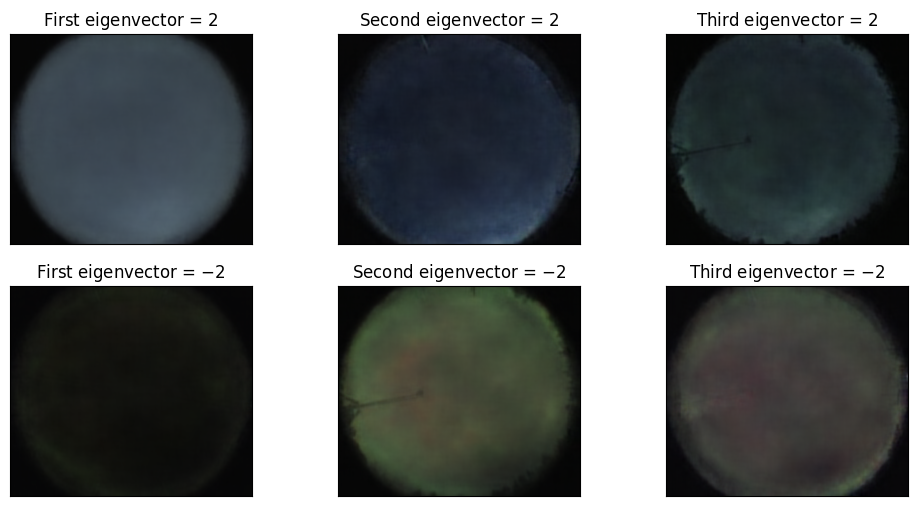

In [16]:
comps = [[2,0,0],[0,2,0],[0,0,2],[-2,0,0],[0,-2,0],[0,0,-2]]
titles = [r'First eigenvector = $2$', r'Second eigenvector = $2$', r'Third eigenvector = $2$', r'First eigenvector = $-2$', r'Second eigenvector = $-2$', r'Third eigenvector = $-2$', ]
plt.figure(figsize=[12,6])
for i, comp in enumerate(comps):
    plt.subplot(2,3,i+1)
    comp = np.array(comp)
    image = np.clip(model.layers[1](np.einsum('i,ij',comp,pca.components_[:len(comp)])).transpose(1,2,0)*stds+means,0,1)
    plt.imshow(image)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()    

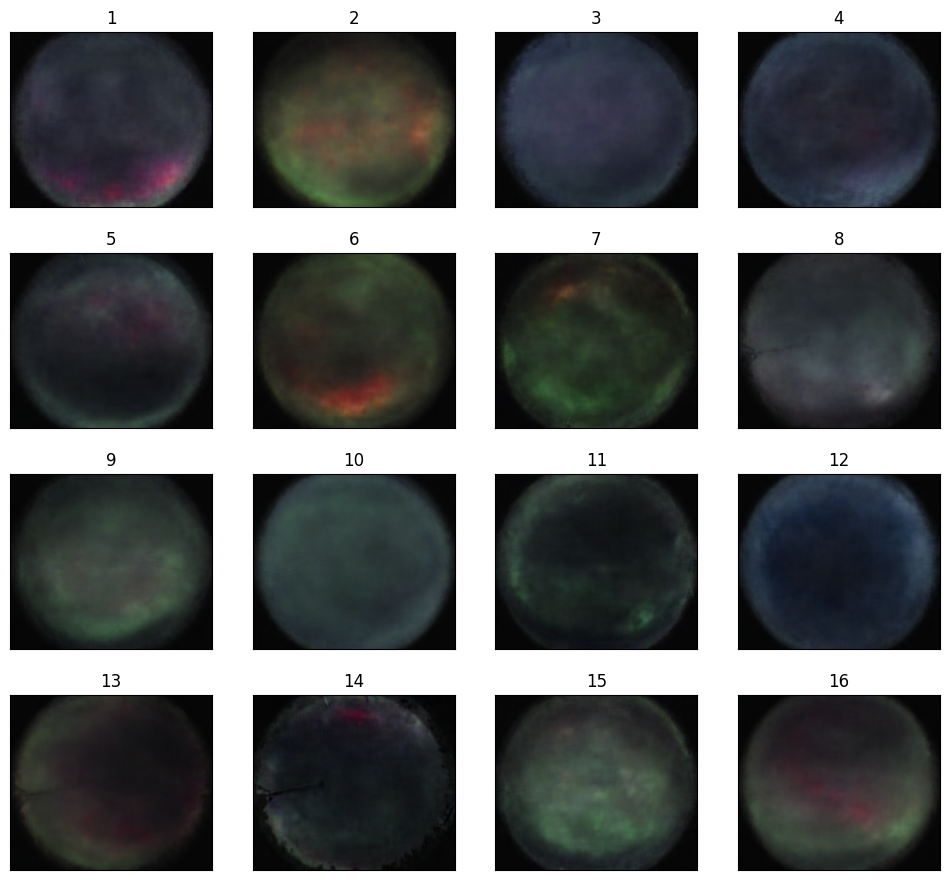

In [17]:
comps = np.random.uniform(-1,1, size=(16,16))
# comps = scipy.stats.truncnorm.rvs(-1,1, size=(16,16))
plt.figure(figsize=[12,11])
for i, comp in enumerate(comps):
    plt.subplot(4,4,i+1)
    comp = np.array(comp)
    image = np.clip(model.layers[1](np.einsum('i,ij',comp,pca.components_[:len(comp)])).transpose(1,2,0)*stds+means,0,1)
    plt.imshow(image)
    plt.title(f'{i+1}')
    plt.xticks([])
    plt.yticks([])
plt.show() 